In [1]:
import asyncio
import time
import logging

import vector; vector.register_awkward()

import awkward as ak
import cabinetry
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms
from func_adl import ObjectStream
import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import uproot

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.getLogger("cabinetry").setLevel(logging.INFO)

In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 10

# pipeline to use:
# - "coffea" for pure coffea setup
# - "servicex_processor" for coffea with ServiceX processor
# - "servicex_databinder" for downloading query output and subsequent standalone coffea
PIPELINE = "coffea"

# enable Dask (may not work yet in combination with ServiceX outside of coffea-casa)
USE_DASK = True

# ServiceX behavior: ignore cache with repeated queries
SERVICEX_IGNORE_CACHE = True

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "coffea_casa"

In [3]:
processor_base = processor.ProcessorABC if (PIPELINE != "servicex_processor") else servicex.Analysis

# functions creating systematic variations
def flat_variation(ones):
    # 2.5% weight variations
    return (1.0 + np.array([0.025, -0.025], dtype=np.float32)) * ones[:, None]


def btag_weight_variation(i_jet, jet_pt):
    # weight variation depending on i-th jet pT (7.5% as default value, multiplied by i-th jet pT / 50 GeV)
    return 1 + np.array([0.075, -0.075]) * (ak.singletons(jet_pt[:, i_jet]) / 50).to_numpy()


def jet_pt_resolution(pt):
    # normal distribution with 5% variations, shape matches jets
    counts = ak.num(pt)
    pt_flat = ak.flatten(pt)
    resolution_variation = np.random.normal(np.ones_like(pt_flat), 0.05)
    return ak.unflatten(resolution_variation, counts)


class TtbarAnalysis(processor_base):
    def __init__(self):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )

    def process(self, events):
        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.

        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        #### systematics
        # example of a simple flat weight variation, using the coffea nanoevents systematics feature
        if process == "wjets":
            events.add_systematic("scale_var", "UpDownSystematic", "weight", flat_variation)

        # jet energy scale / resolution systematics
        # need to adjust schema to instead use coffea add_systematic feature, especially for ServiceX
        # cannot attach pT variations to events.jet, so attach to events directly
        # and subsequently scale pT by these scale factors
        events["pt_nominal"] = 1.0
        events["pt_scale_up"] = 1.03
        events["pt_res_up"] = jet_pt_resolution(events.jet.pt)

        pt_variations = ["pt_nominal", "pt_scale_up", "pt_res_up"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:

            ### event selection
            # very very loosely based on https://arxiv.org/abs/2006.13076

            # pT > 25 GeV for leptons & jets
            selected_electrons = events.electron[events.electron.pt > 25]
            selected_muons = events.muon[events.muon.pt > 25]
            jet_filter = events.jet.pt * events[pt_var] > 25  # pT > 25 GeV for jets (scaled by systematic variations)
            selected_jets = events.jet[jet_filter]

            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # at least four jets
            pt_var_modifier = events[pt_var] if "res" not in pt_var else events[pt_var][jet_filter]
            event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
            # at least one b-tagged jet ("tag" means score above threshold)
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)

            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            
            for region in ["4j1b", "4j2b"]:
                # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
                if region == "4j1b":
                    region_filter = ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) == 1
                    selected_jets_region = selected_jets[region_filter]
                    selected_electrons_region = selected_electrons[region_filter]
                    selected_muons_region = selected_muons[region_filter]
                    
                    # use HT (scalar sum of jet pT) as observable
                    pt_var_modifier = events[event_filters][region_filter][pt_var] if "res" not in pt_var else events[pt_var][jet_filter][event_filters][region_filter]
                    observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)
                    
                    # get pt of either muon or electron (there should be exactly one of either for each event)
                    lepton_pt = ak.sum(selected_electrons_region.pt,axis=-1) + ak.sum(selected_muons_region.pt,axis=-1) 
                    

                elif region == "4j2b":
                    region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
                    selected_jets_region = selected_jets[region_filter]
                    selected_electrons_region = selected_electrons[region_filter]
                    selected_muons_region = selected_muons[region_filter]

                    if PIPELINE == "servicex_processor":
                        import vector

                        vector.register_awkward()

                        # wrap into a four-vector object to allow addition
                        selected_jets_region = ak.zip(
                            {
                                "pt": selected_jets_region.pt, "eta": selected_jets_region.eta, "phi": selected_jets_region.phi,
                                "mass": selected_jets_region.mass, "btag": selected_jets_region.btag,
                            },
                            with_name="Momentum4D",
                        )

                    # reconstruct hadronic top as bjj system with largest pT
                    # the jet energy scale / resolution effect is not propagated to this observable at the moment
                    trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                    trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
                    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
                    # pick trijet candidate with largest pT and calculate mass of system
                    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                    observable = ak.flatten(trijet_mass)
                    
                    # get pt of either muon or electron (there should be exactly one of either for each event)
                    lepton_pt = ak.sum(selected_electrons_region.pt,axis=-1) + ak.sum(selected_muons_region.pt,axis=-1) 
                    
                    # get pt of leading jet
                    lj_pt = ak.max(selected_jets_region.pt,axis=-1)

                ### histogram filling
                if pt_var == "pt_nominal":
                    # nominal pT, but including 2-point systematics
                    histogram.fill(
                            observable=observable, region=region, process=process, variation=variation, weight=xsec_weight
                        )

                    if variation == "nominal":
                        # also fill weight-based variations for all nominal samples
                        for weight_name in events.systematics.fields:
                            for direction in ["up", "down"]:
                                # extract the weight variations and apply all event & region filters
                                weight_variation = events.systematics[weight_name][direction][f"weight_{weight_name}"][event_filters][region_filter]
                                # fill histograms
                                histogram.fill(
                                    observable=observable, region=region, process=process, variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                        # calculate additional systematics: b-tagging variations
                        for i_var, weight_name in enumerate([f"btag_var_{i}" for i in range(4)]):
                            for i_dir, direction in enumerate(["up", "down"]):
                                # create systematic variations that depend on object properties (here: jet pT)
                                if len(observable):
                                    weight_variation = btag_weight_variation(i_var, selected_jets_region.pt)[:, i_dir]
                                else:
                                    weight_variation = 1 # no events selected
                                histogram.fill(
                                    observable=observable, region=region, process=process, variation=f"{weight_name}_{direction}", weight=xsec_weight*weight_variation
                                )

                elif variation == "nominal":
                    # pT variations for nominal samples
                    histogram.fill(
                            observable=observable, region=region, process=process, variation=pt_var, weight=xsec_weight
                        )

        features = ak.zip((observable, lepton_pt, lj_pt))
        if process=='ttbar':
            labels = ak.ones_like(observable)
        else:
            labels = ak.zeros_like(observable)
        
        output = {"nevents": {events.metadata["dataset"]: len(events)}, 
                  "hist": histogram,
                  "features": {events.metadata["dataset"]: features.to_list()}, 
                  "labels": {events.metadata["dataset"]: labels.to_list()}}

        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [5]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

process =  ttbar
variation =  nominal
variation =  scaledown
variation =  scaleup
variation =  ME_var
variation =  PS_var
process =  single_top_s_chan
variation =  nominal
process =  single_top_t_chan
variation =  nominal
process =  single_top_tW
variation =  nominal
process =  wjets
variation =  nominal
processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/merged/TT_TuneCUETP8M1_13TeV-powheg-pythia8/1.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 4370893, 'xsec': 729.84}
}


In [6]:
t0 = time.time()

if PIPELINE == "coffea":
    if USE_DASK:
        executor = processor.DaskExecutor(client=utils.get_client(AF))
    else:
        executor = processor.IterativeExecutor()

    from coffea.nanoevents.schemas.schema import auto_schema
    schema = AGCSchema if PIPELINE == "coffea" else auto_schema
    run = processor.Runner(executor=executor, schema=schema, savemetrics=True, metadata_cache={})
    
    all_histograms, metrics = run(fileset, "events", processor_instance=TtbarAnalysis())
    
    all_features = all_histograms["features"]
    all_labels = all_histograms["labels"]
    all_histograms = all_histograms["hist"]


print(f"\nexecution took {time.time() - t0:.2f} seconds")

[########################################] | 100% Completed |  1min 59.4s
execution took 131.00 seconds


In [7]:
import math

features = all_features['ttbar__nominal'] + all_features['single_top_tW__nominal'] + all_features['wjets__nominal'] + all_features['single_top_s_chan__nominal'] + all_features['single_top_t_chan__nominal']
labels = all_labels['ttbar__nominal'] + all_labels['single_top_tW__nominal'] + all_labels['wjets__nominal'] + all_labels['single_top_s_chan__nominal'] + all_labels['single_top_t_chan__nominal']

from sklearn.model_selection import train_test_split

train_ratio = 0.8
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=1-train_ratio, random_state=5)

In [8]:
from sklearn.neighbors import KNeighborsClassifier

k_vals = np.arange(3,15,2,dtype=int)
for k in k_vals:
    model = KNeighborsClassifier(n_neighbors=k)

    # Train the model using the training sets
    model.fit(features_train,labels_train)
    # Test the model using the test sets
    score = model.score(features_test, labels_test)

    print("k = ", k, ", Efficiency = ", 100*score, "%")

k =  3 , Efficiency =  54.129881916295005 %
k =  5 , Efficiency =  55.020166001239424 %
k =  7 , Efficiency =  55.623960799054515 %
k =  9 , Efficiency =  56.140047883670455 %
k =  11 , Efficiency =  56.53388599351843 %
k =  13 , Efficiency =  56.96565176312822 %


In [9]:
from sklearn.tree import DecisionTreeClassifier

max_depth_vals = np.arange(5,50,5,dtype=int)
for max_depth in max_depth_vals:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=2)

    # Train the model using the training sets
    model.fit(features_train,labels_train)
    score = model.score(features_test, labels_test)

    print("max_depth = ", max_depth, ", Efficiency = ", 100*score, "%")

max_depth =  5 , Efficiency =  60.317170054758066 %
max_depth =  10 , Efficiency =  60.296851665599945 %
max_depth =  15 , Efficiency =  59.90775451322219 %
max_depth =  20 , Efficiency =  59.26162973799437 %
max_depth =  25 , Efficiency =  58.36525013630253 %
max_depth =  30 , Efficiency =  57.36660130918154 %
max_depth =  35 , Efficiency =  56.37506391826589 %
max_depth =  40 , Efficiency =  55.39639484048371 %
max_depth =  45 , Efficiency =  54.599575345666594 %


In [10]:
all_histograms.axes

(Regular(25, 50, 550, name='observable', label='observable [GeV]'),
 StrCategory(['4j1b', '4j2b'], name='region', label='Region'),
 StrCategory(['ttbar', 'wjets', 'single_top_t_chan', 'single_top_tW', 'single_top_s_chan'], growth=True, name='process', label='Process'),
 StrCategory(['nominal', 'btag_var_0_up', 'btag_var_0_down', 'btag_var_1_up', 'btag_var_1_down', 'btag_var_2_up', 'btag_var_2_down', 'btag_var_3_up', 'btag_var_3_down', 'pt_scale_up', 'pt_res_up', 'scale_var_up', 'scale_var_down', 'PS_var', 'ME_var', 'scaleup', 'scaledown'], growth=True, name='variation', label='Systematic variation'))

In [11]:
all_histograms.values().shape

(25, 2, 5, 17)

In [12]:
# this is 4j1b, ttbar, nominal
all_histograms[:,0,0,0]

Hist(Regular(25, 50, 550, name='observable', label='observable [GeV]'), storage=Weight()) # Sum: WeightedSum(value=224625, variance=126700) (WeightedSum(value=252754, variance=142566) with flow)

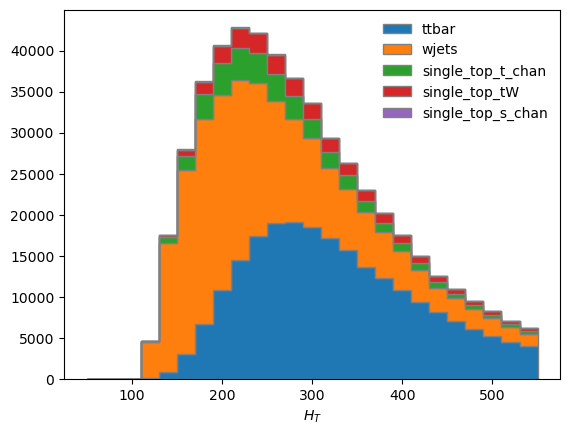

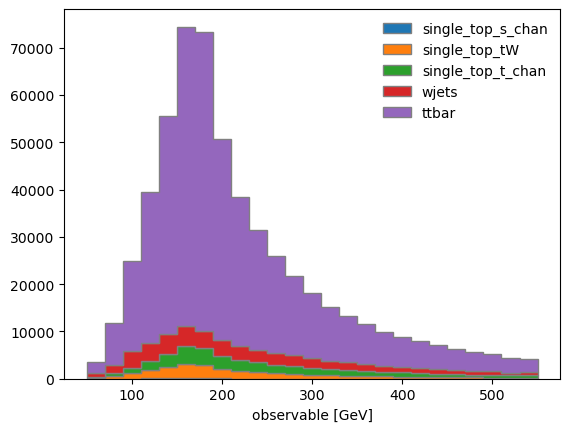

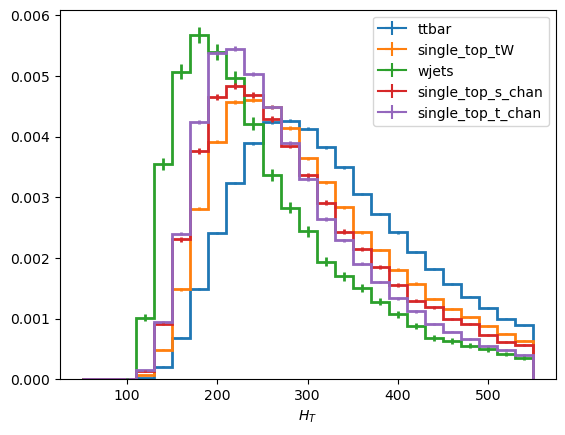

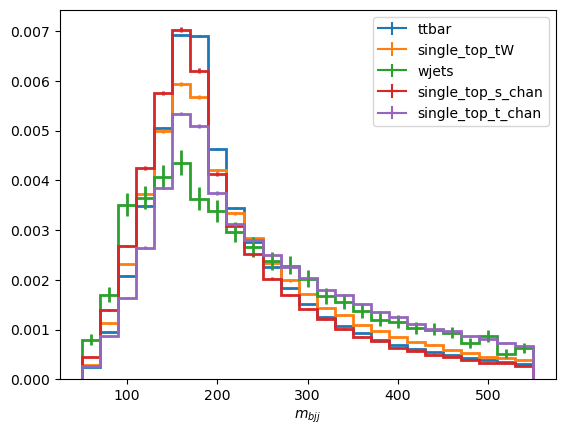

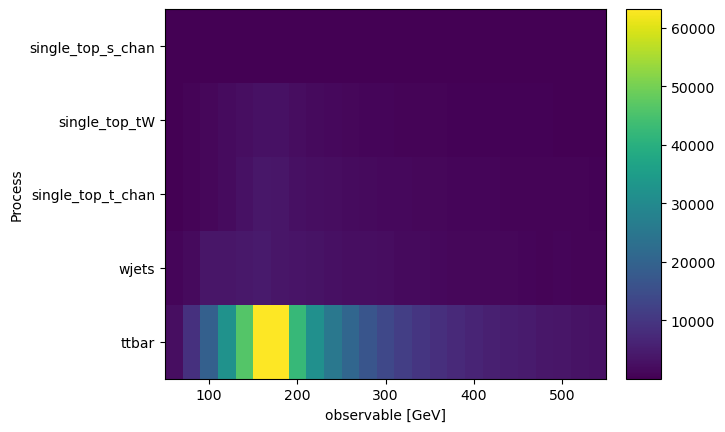

In [13]:
# this is 4j1b (HT), all, nominal
all_histograms[:,'4j1b',:,'nominal'].stack('process').plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.xlabel('$H_T$')
plt.show()

# this is 4j2b, all, nominal
all_histograms[:,'4j2b',:,'nominal'].stack('process')[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.show()

all_histograms[:, "4j1b", "ttbar", "nominal"].plot(label="ttbar", linewidth=2, density=True)
all_histograms[:, "4j1b", "single_top_tW", "nominal"].plot(label="single_top_tW", linewidth=2, density=True)
all_histograms[:, "4j1b", "wjets", "nominal"].plot(label="wjets", linewidth=2, density=True)
all_histograms[:, "4j1b", "single_top_s_chan", "nominal"].plot(label="single_top_s_chan", linewidth=2, density=True)
all_histograms[:, "4j1b", "single_top_t_chan", "nominal"].plot(label="single_top_t_chan", linewidth=2, density=True)
plt.xlabel('$H_T$')
plt.legend()
plt.show()

all_histograms[:, "4j2b", "ttbar", "nominal"].plot(label="ttbar", linewidth=2, density=True)
all_histograms[:, "4j2b", "single_top_tW", "nominal"].plot(label="single_top_tW", linewidth=2, density=True)
all_histograms[:, "4j2b", "wjets", "nominal"].plot(label="wjets", linewidth=2, density=True)
all_histograms[:, "4j2b", "single_top_s_chan", "nominal"].plot(label="single_top_s_chan", linewidth=2, density=True)
all_histograms[:, "4j2b", "single_top_t_chan", "nominal"].plot(label="single_top_t_chan", linewidth=2, density=True)
plt.xlabel('$m_{bjj}$')
plt.legend()
plt.show()

# same as above but 2d instead of stacked
all_histograms[:,'4j2b',:,'nominal'].plot2d()
plt.show()

In [14]:
all_histograms[10,0,0,0].value

19019.745350526886

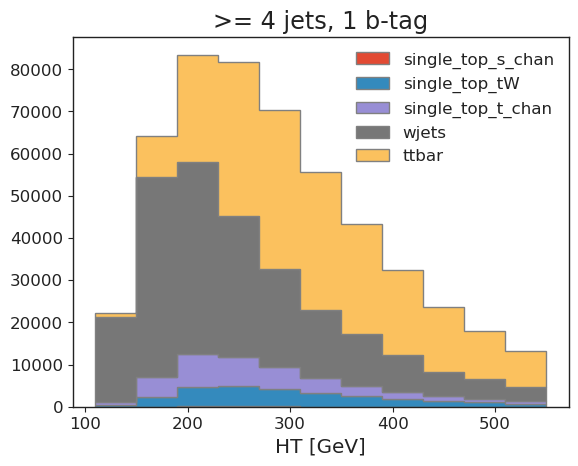

In [15]:
utils.set_style()

all_histograms[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, 1 b-tag")
plt.xlabel("HT [GeV]");

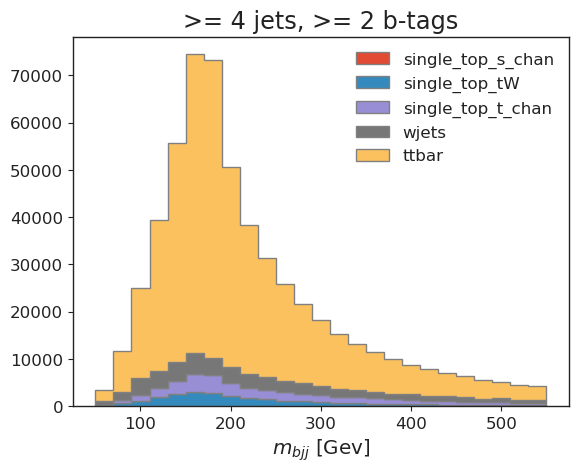

In [16]:
all_histograms[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags")
plt.xlabel("$m_{bjj}$ [Gev]");